# How to guide
This guide will show how to carry out key nchack operations. We will use a sea surface temperature data set and a depth-resolved ocean temperature data set.
The data sets can be downloaded using wget as follows:

In [1]:
import nchack as nc
import pandas as pd
import xarray as xr
from IPython.display import clear_output

In [2]:
# ! wget ftp://ftp.cdc.noaa.gov/Datasets/COBE2/sst.mon.mean.nc
# clear_output()

## How to select years and months
If we want to select specific years and months we can use the select_years and select_months method

In [3]:
sst = nc.open_data("sst.mon.mean.nc")
sst.select_years(1960)
sst.select_months(1)
sst.times()

0    1960-01-01T00:00:00
dtype: object

## How to copy a data set
If you want to make a deep copy of a data set, use the built in copy method. This method will return a new data set. Importantly, this method will also register the current state of the data set in a list of "safe files" that is only available to the module. This ensures that temporary files are deleted correctly. 

In [4]:
sst = nc.open_data("sst.mon.mean.nc")
sst.select_years(1960)
sst.select_months(1)
sst1 = sst.copy()
del sst
sst1.mean()
sst1.autoplot()

## How to clip to a region 
If you want to clip the data to a specific longitude and latitude box, we can use clip, with the longitude and latitude range given by lon and lat.

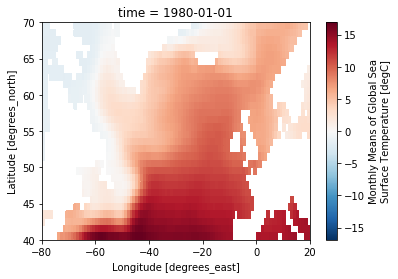

In [5]:
sst = nc.open_data("sst.mon.mean.nc")
sst.select_months(1)
sst.select_years(1980)
sst.clip(lon = [-80, 20], lat = [40, 70])
sst.autoplot()

## How to rename a variable
If we want to rename a variable we use the rename method, and supply a dictionary where the key, value pairs are the original and new names

In [6]:
sst = nc.open_data("sst.mon.mean.nc")
sst.variables
sst.rename({"sst": "temperature"})
sst.variables

['temperature']

## How to create new variables
New variables can be created using arithmetic operations using either mutate or transmute. The mutate method will maintain the original variables, whereas transmute will not.
This method requires a dictionary, where the key, values pairs are the names of the new variables and the arithemtic operations to perform.
The example below shows how to create a new variable with 

In [7]:
sst = nc.open_data("sst.mon.mean.nc")
sst.mutate({"sst_k": "sst+273.15"})
sst.variables

['sst', 'sst_k']

## How to calculate a spatial average
You can calculate a spatial average using the spatial_mean method. There are additional methods for maximums etc.

In [8]:
sst = nc.open_data("sst.mon.mean.nc")
sst.spatial_mean()
sst.autoplot()

:Curve   [time]   (x)

## How to calculate an annual mean
You can calculate an annual mean using the annual_mean method.

In [9]:
sst = nc.open_data("sst.mon.mean.nc")
sst.spatial_mean()
sst.annual_mean()
sst.autoplot()

:Curve   [time]   (x)

## How to calculate a rolling average
You can calculate a rolling mean using the rolling_mean method, with the window argument providing the number of time steps to average over. There are additional methods for rolling sums etc.
The code below will calculate a rolling mean of global SST using a 20 year window.

In [10]:
sst = nc.open_data("sst.mon.mean.nc")
sst.spatial_mean()
sst.annual_mean()
sst.rolling_mean(20)
sst.autoplot()

:Curve   [time]   (x)

## How to calculate temporal anomalies
You can calculate annual temporal anomalies using the anomaly_annual method. This requires a baseline period.

In [11]:
sst = nc.open_data("sst.mon.mean.nc")
sst.spatial_mean()
sst.annual_anomaly(baseline = [1960, 1979])
sst.autoplot()

:Curve   [time]   (x)

## How to split data by year etc
Files within a dataset can be split by year, day, year and month or season using the split method. If we wanted to split by year, we do the following: 

In [12]:
sst = nc.open_data("sst.mon.mean.nc")
sst.split("year")
sst.size

Number of files in ensemble: 169
Ensemble size: 530.111595 MB
Smallest file /tmp/nchackucmfaarbnchacktmp_155u76o.1962.nc has size 3.136755 MB
Largest file /tmp/nchackucmfaarbnchacktmp_155u76o.1962.nc has size 3.136755 MB


## How to merge files in time
We can merge files based on time using merge_time. The code below splits the netcdf files by year and then merges them using merge_time.

In [13]:
sst = nc.open_data("sst.mon.mean.nc")
sst.split("year")
sst.size
sst.merge_time()
sst.size

Number of files in ensemble: 169
Ensemble size: 530.111595 MB
Smallest file /tmp/nchackucmfaarbnchacktmp5r688br9.1996.nc has size 3.136755 MB
Largest file /tmp/nchackucmfaarbnchacktmp5r688br9.1996.nc has size 3.136755 MB
Number of files: 1
File size: 525.8241770000001 MB


## How to do variables based merging
If we have two more more files that have the same time steps, but different variables, we can merge them using merge.
The code below will first create a dataset with a netcdf file with sst in K, and it will then create a new dataset with this netcd file and the original, and then merge them.

In [14]:
sst1 = nc.open_data("sst.mon.mean.nc")
sst2 = nc.open_data("sst.mon.mean.nc")
sst2.transmute({"sst_k": "sst+273.15"})
new_sst = nc.open_data([sst1.current, sst2.current])
new_sst.current
new_sst.merge()
new_sst.variables

CDO warning: Duplicate entry of parameter -1 in /tmp/nchackucmfaarbnchacktmpeud1ybsr.nc!


['sst', 'sst_k']

In some cases we will have two or more datasets we want to merge. In this case we can use the merge function as follows:

In [15]:
sst1 = nc.open_data("sst.mon.mean.nc")
sst2 = nc.open_data("sst.mon.mean.nc")
sst2.transmute({"sst_k": "sst+273.15"})
new_sst = nc.merge(sst1, sst2)
new_sst.variables

CDO warning: Duplicate entry of parameter -1 in sst.mon.mean.nc!


['sst_k', 'sst']

## How to horizontally regrid data 
Variables can be regridded horizontally using regrid. This method requires the new grid to be defined. This can either be a pandas data frame, with lon/lat as columns, an xarray object, a netcdfile or a dataset.
I will demonstrate all three methods by regridding SST to the North Atlantic.
Let's begin by getting a grid for the North Atlantic.

In [16]:
new_grid = nc.open_data("sst.mon.mean.nc")
new_grid.clip(lon = [-80, 20], lat = [30, 70])
new_grid.select_months(1)
new_grid.select_years( 2000)

First, we will use the new dataset itself to do the regridding. I will calculate mean SST using the original data, and then regrid to the North Atlantic.

CDO warning: HDF5 support not compiled in!
CPU times: user 99.3 ms, sys: 170 ms, total: 269 ms
Wall time: 2.92 s


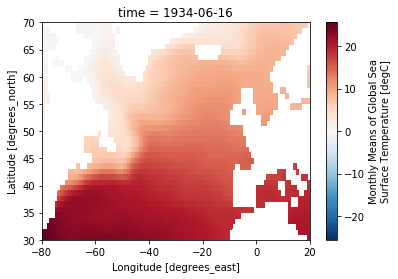

In [17]:
%%time
sst = nc.open_data("sst.mon.mean.nc")
sst.mean()
sst.regrid(grid = new_grid)
sst.autoplot()

We can also do this using the netcdf, which is new_grid.current

CDO warning: HDF5 support not compiled in!
CPU times: user 68.3 ms, sys: 117 ms, total: 185 ms
Wall time: 2.72 s


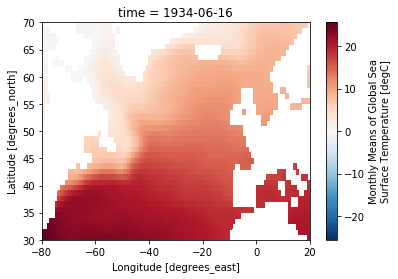

In [18]:
%%time
sst = nc.open_data("sst.mon.mean.nc")
sst.mean()
sst.regrid(grid = new_grid.current)
sst.autoplot()

In a similar way we can read the new_grid in as an xarray data set.

CDO warning: HDF5 support not compiled in!
CPU times: user 83 ms, sys: 94.7 ms, total: 178 ms
Wall time: 2.91 s


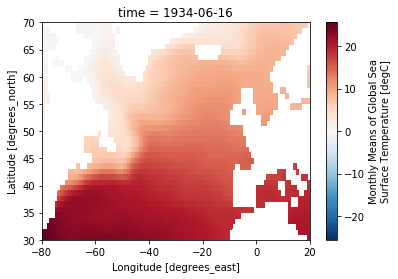

In [19]:
%%time
na_grid = xr.open_dataset(new_grid.current)
sst = nc.open_data("sst.mon.mean.nc")
sst.mean()
sst.regrid(grid = na_grid)
sst.autoplot()

or we can use a pandas data frame. In this case I will convert the xarray data set to a data frame.

CPU times: user 246 ms, sys: 74.7 ms, total: 321 ms
Wall time: 2.79 s


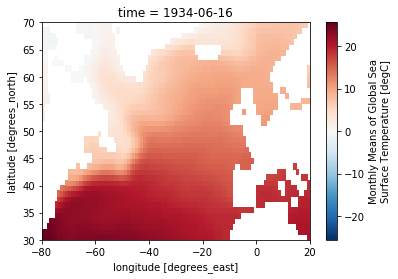

In [20]:
%%time
na_grid = xr.open_dataset(new_grid.current)
na_grid = na_grid.to_dataframe().reset_index().loc[:,["lon", "lat"]]
sst = nc.open_data("sst.mon.mean.nc")
sst.mean()
sst.regrid(grid = na_grid)
sst.autoplot()

## How to temporally interpolate
Temporal interpolation can be carried out using time_interp. This method requires a start date (start) of the format YYYY/MM/DD and an end date (end), and a temporal resolution (resolution), which is either 1 day ("daily"), 1 week ("weekly"), 1 month ("monthly"), or 1 year ("yearly"). 

In [21]:
sst = nc.open_data("sst.mon.mean.nc")
sst.time_interp(start = "1990/01/01", end = "1990/12/31", resolution = "daily")

## How to calculate a monthly average from daily data
If you have daily data, you can calculate a month average using monthly_mean. There are also methods for maximums etc.

In [22]:
sst = nc.open_data("sst.mon.mean.nc")
sst.time_interp(start = "1990/01/01", end = "1990/12/31", resolution = "daily")
sst.monthly_mean()

## How to calculate a monthly climatology
CDO outputs the date of the final month.

In [23]:
sst = nc.open_data("sst.mon.mean.nc")
sst.select_years(list(range(1990, 2000)))
sst.monthly_mean_climatology()
sst.autoplot()

:HoloMap   [time]
   :Image   [lon,lat]   (sst)

## How to calculate a seasonal climatology

In [24]:
sst = nc.open_data("sst.mon.mean.nc")
sst.seasonal_mean_climatology()
sst.autoplot()

:HoloMap   [time]
   :Image   [lon,lat]   (sst)